This is a short post about alogrithms for debt simplification: reducing a list of debts among a set of people to the smallest possible number of transfers. This is a common problem for groups of friends or roomates, and the solution is implemented in various apps and websites, such as Splitwise, Tricount, and others.

{% include mathjax.html %}

To make this work, we make the assumption that debt is transferable, that is, if A owes \\$5 to B, and B owes \\$5 to C, we can convert this into a single \\$5 transfer from A to C.

An interesting property of this problem is that getting to the optimal set of transfers is NP-complete, but we can get a solution with at most (number of people) - 1 transfers in linear time in the number of transactions.

## A simple solution

There is a straightforward solution that is linear in \{number of transactions + number of people\}.

Let's start with a set of people and debts. We'll take the convention that `("Grace", "Ivan", 5)` means Grace owes Ivan \\$5. We call Grace the _debtor_ and Ivan the _creditor_.

In [1]:
people = ["Grace", "Ivan", "Judy", "Luke", "Mallory"]
debts = [
    ("Grace", "Ivan", 5),
    ("Grace", "Judy", 3),
    ("Ivan", "Grace", 2),
    ("Ivan", "Mallory", 5),
    ("Judy", "Grace", 10),
    ("Judy", "Luke", 4),
    ("Judy", "Mallory", 6),
    ("Judy", "Mallory", 2),
    ("Luke", "Ivan", 4),
    ("Mallory", "Grace", 15),
    ("Mallory", "Luke", 6),
    ("Mallory", "Judy", 11),
]

Next, let's compute everybody's balance. The balance is the net amount of money someone must receive from all other members of the group (it can be negative if the person is a net debtor). Any set of transactions we come up with must preserve everybody's balance. In fact, a set of transaction is correct _if and only if_ it does so: everybody must pay or receive as much money as they owed or were owed initially, and this is the only constraint on the solution we must pick.

Since there is no debt going in or out of the group as a whole, the sum of everybody's balances must be 0.

In [2]:
def compute_balances(debts):
    balances = {person: 0 for person in people}
    for (debtor, creditor, value) in debts:
        balances[debtor] -= value
        balances[creditor] += value
    return balances
compute_balances(debts)

{'Grace': 19, 'Ivan': 2, 'Judy': -8, 'Luke': 6, 'Mallory': -19}

Once we have balances, we can pick someone at random who we'll call the _collector_ (let's take Grace as an example). Everybody with a negative balance will pay Grace for their total debt amount (to everybody in the group, not just Grace), and Grace will pay everybody with a positive balance for their total credit amount. We don't include any other transactions in our solution set.

Clearly, everybody who isn't Grace has their balance preserved: they have a single transaction for their balance amount. What about Grace herself?

We know that the total balance of the group is 0, so Grace's balance must be the opposite of the sum of everybody else's balance, or, denotig each person's balance as $b_p$,

$$
b_\mathrm{Grace} = -\sum_{p\in\mathrm{group},\, p\neq\mathrm{Grace}} b_p.
$$

But $-\sum_{p\in\mathrm{group},\, p\neq\mathrm{Grace}} b_p$ is exactly the net amount of money Grace is receiving, because she has one transaction for each other person in the group, worth exactly their balance.

In sum, this solution satisfies our balance constraints, so it's an allowable way for the group to resolve their debts. There are $n - 1$ transactions at most (there may be fewer if anybody's balance is exactly 0), where _n_ is the number of people in the group: one for each person, except for the collector.

In [3]:
def simplify_with_collector(balances):
    collector = next(iter(balances.keys()))
    return [(collector, person, balance) for (person, balance)
            in balances.items() if person != collector]

def show_transactions(transactions):
    for (debtor, creditor, value) in transactions:
        if value > 0:
            print(f"{debtor} owes {creditor} ${value}")
        else:
            print(f"{creditor} owes {debtor} ${-value}")
            
collector_transactions = simplify_with_collector(compute_balances(debts))
show_transactions(collector_transactions)

Grace owes Ivan $2
Judy owes Grace $8
Grace owes Luke $6
Mallory owes Grace $19


With the [NetworkX](https://networkx.github.io/) library and [matplotlib](https://matplotlib.org/), we can easily view the result as graph. Looking at graphs will be useful later, so let's introduce this now:

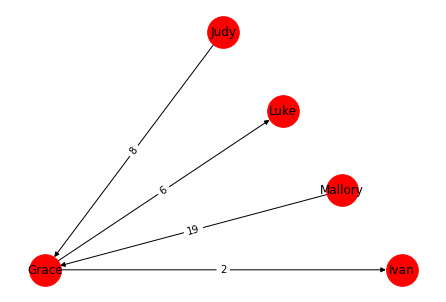

In [4]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(people)
G.add_weighted_edges_from(collector_transactions)

# Some of the graphs we make have edges with negative values, which
# is confusing. This function just inverts the direction of all
# negative-valued edges.
def reorient_digraph(G):
    NG = nx.DiGraph()
    NG.add_nodes_from(G.nodes)
    for (start, end) in G.edges:
        weight = G[start][end]['weight']
        if weight > 0:
            NG.add_edge(start, end, weight=weight)
        else:
            NG.add_edge(end, start, weight=-weight)
    return NG

def print_digraph(G, pos):
    nx.draw(G, pos, with_labels=True, node_color='r', node_size=1000)
    labels = nx.get_edge_attributes(G, 'weight')
    _ = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

print_digraph(reorient_digraph(G), nx.planar_layout(G))

This solution's complexity is $O(m + n)$, where _m_ is the number of initial debts we consider, and _n_ is the number of people; the only real work is to go over the _m_ debts and compute balances, then add _n_ transactions.

In practice, this solution is pretty good: it's fast to compute, and each person except the collector has at most 1 transaction to make. On the other hand, the collector is part of $n - 1$ transactions, which can be a lot.

### Optimality of the linear-time solution

There are sets of initial debts that can never be resolved in less than $n - 1$ transactions (one instance is when everybody has a balance of -1, except for one person who has a balance of _n_)[^1]. So there are at least some cases for which our algorithm gives the optimal answer.

[^1]: Exercise for the reader: prove this example really cannot be solved in fewer transactions.

However, there are also cases where this is not optimal at all. Consider a set of $2k$ friends, where half of the people have a balance of -1, and the other half have a balance of 1. Our algorithm would result in $2k - 1$ transactions, but these debts can be resolved in _k_ transfers by pairing each debtor with a creditor.

So just how bad is our algorithm doing? Well, each person with a nonzero balance will have to make at least one transaction. A transaction involves exactly two people, so if there are _n_ people, there must be at least $n/2$ transactions. Our linear-time algorithm can easily exclude people with a 0 balance as well and still run in linear time, so we end up with $n-1$ versus $n/2$: the linear-time algorithm is at most a factor of 2 off.

Unfortunately, finding the optimal solution is an NP-complete problem. It's actually [decently common for NP-hard problems to be approximable by a P algorithm](https://en.wikipedia.org/wiki/Hardness_of_approximation); for instance, [the travelling salesman problem as a P approximation that is off by a factor of 1.5 at most](https://en.wikipedia.org/wiki/Christofides_algorithm).

## An optimal solution

First, let's characterize the cases when we can go below $n - 1$ transactions. Let's consider a graph of the various transactions at play, where the nodes are people, and the edges are transactions.

Any graph with $n$ points and less than $n - 1$ edges can't be connected, so if there are less than $n - 1$ transactions, there must be at least two separate components to the graph in our optimal solution. Equivalently, there must be two subgroups of people who can fully settle their debts internally. Each such subgroup must have an aggregate balance of 0, otherwise this subgroup as a whole would owe money to the rest of the people, and we would have to add transactions connecting it to the rest of the group.

In fact, if we have $n - 1 - k$ total transactions for some _k_, we must have exactly _k_ connected components in the graph, and each component must have a balance of 0.

So the optimal solution is to find as many disjoint subgroups of people as possible whose total balance is 0, then treat each subgroup as a separate problem, applying the linear solution above.

Let's start by finding all subsets of people whose aggregate balance is 0. This part is basically the [subset sum](https://en.wikipedia.org/wiki/Subset_sum_problem) problem, which [is NP-complete](https://www.cs.cornell.edu/courses/cs4820/2018fa/lectures/subset_sum.pdf). I'm fully brute-forcing it here; there are usually ways to optimize some parts of this type of problem, but I can't be bothered.

In [5]:
import itertools

def find_zero_subset(balances):
    for i in range(1, len(balances)):
        for subset in itertools.combinations(balances.items(), i):
            if sum([balance[1] for balance in subset]) == 0:
                return [balance[0] for balance in subset]
    return None

remaining_set = compute_balances(debts)
subsets = []
while (subset := find_zero_subset(remaining_set)) is not None:
    subsets.append(subset)
    remaining_set = {x[0]: x[1] for x in remaining_set.items() if x[0] not in subset}
subsets.append(list(remaining_set.keys()))
subsets

[['Grace', 'Mallory'], ['Ivan', 'Judy', 'Luke']]

We have two subgroups, so we can expect $(n - 1) - (2 - 1) = n - 2 = 3$ transactions in the final solution. We can now apply the solution from the previous section to each subgroup:

In [6]:
balances = compute_balances(debts)
optimal_transactions = []
for subset in subsets:
    subset_balances = {person: balances[person] for person in subset}
    optimal_transactions.extend(simplify_with_collector(subset_balances))
show_transactions(optimal_transactions)

Mallory owes Grace $19
Judy owes Ivan $8
Ivan owes Luke $6


What does this look like as a graph?

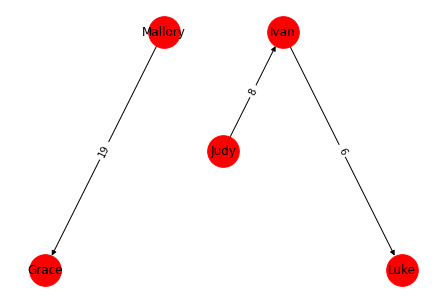

In [7]:
SG = nx.DiGraph()
SG.add_nodes_from(people)
SG.add_weighted_edges_from(optimal_transactions)
print_digraph(reorient_digraph(SG), nx.planar_layout(SG))

We can clearly see the two connected components.

## Variant 1: Minimizing the amount of money transferred

Let's finish with two alternative ways to solve the approximated problem.

The first variant still gets $n - 1$ transactions, but also minimizes the total amount of money transfered between people. This might be the best solution if some proportional fee must be paid for each transfer.

Once again, let's think about what a solution must look like. We know that each person with a positive balance will have to be involved in transactions totaling at least the value of their balance, in order to return to 0. Returning to our previous notation, the best we can hope to do is to have a total transaction value of

$$
\sum_{p\in\mathrm{group},\,b_p>0} b_p.
$$

In fact, we can always achieve this. We can divide the group between net creditors and net debtors, and add transactions from each debtor to as many creditors as it takes to reduce the debt to 0. The following algorithm achieves this:

In [8]:
import random

def simplify_minflow(debts):
    balances = compute_balances(debts)
    transactions = []
    debtors = {p: b for (p, b) in balances.items() if b < 0}
    creditors = {p: b for (p, b) in balances.items() if b > 0}
    
    while debtors:
        (debtor, debt) = next(iter(debtors.items()))
        (creditor, credit) = next(iter(creditors.items()))
        amount = min(-debt, credit)
        transactions.append((debtor, creditor, amount))
        
        creditors[creditor] -= amount
        debtors[debtor] += amount
        if creditors[creditor] == 0:
            del creditors[creditor]
        if debtors[debtor] == 0:
            del debtors[debtor]

    return transactions

minflow_transactions = simplify_minflow(debts)
show_transactions(minflow_transactions)

Judy owes Grace $8
Mallory owes Grace $11
Mallory owes Ivan $2
Mallory owes Luke $6


Looking at the graph, we can see it's [bipartite](https://mathworld.wolfram.com/BipartiteGraph.html): each node has either only outgoing transactions (if it has a starting negative balance), or only incoming transactions (if the starting balance is positive). This is the case for all optimal graphs: as soon as a single person has both inbound and outbound transactions, we know there must be wasted effort, as some of these transactions will bring the person further from a 0 balance.

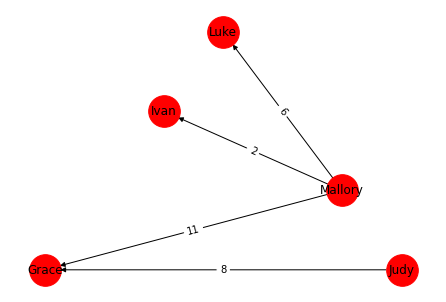

In [9]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(people)
G.add_weighted_edges_from(minflow_transactions)
print_digraph(reorient_digraph(G), nx.planar_layout(G))

This algorithm is also optimal from a number-of-transactions perspective. During each iteration of the loop, we create one transaction and we remove at least one creditor or one debtor by reducing their balance to 0. During the last iteration, we are guaranteed to remove the last creditor *and* the last debtor. Overall, we once again create at most $n - 1$ transactions.

### Complexity

Much like the first solution, this is $O(m + n)$: we need to compute balances in $O(m)$, then create at most $n - 1$ transactions in $O(n)$ total.

## Variant 2: No new transactions

This first algorithm also gives at most $n - 1$ transactions in a graph, but with the added constraint that it will never create a transaction between two people who do not have a debt to start with. This can be advantageous in large groups, if we want to avoid designating a collector who will have a lot of work to do.

First, we'll tidy up the list of debts:
 - We convert all debt so that the debtor comes before the creditor, alphabetically. The debt may become negative as a result. This is a technical trick that will make our life easier later on.
 - We group together all debt owed by the same debtor to the same creditor.
 - We remove any 0-valued debt, or debt whith the same creditor and debtor.

In [10]:
def order_debt(debt):
    debtor, creditor, value = debt
    if debtor < creditor:
        return debt
    else:
        return (creditor, debtor, -value)
    
def filter_debt(debt):
    debtor, creditor, value = debt
    return value != 0 and debtor != creditor

def tidy_debts(debt_list):
    ordered = sorted([order_debt(d) for d in debt_list if order_debt(d) is not None])
    grouped = itertools.groupby(ordered, lambda debt: (debt[0], debt[1]))
    summed = [(key[0], key[1], sum([d[2] for d in debts])) for (key, debts) in grouped]
    return [d for d in summed if filter_debt(d)]

summed = tidy_debts(debts)
summed

[('Grace', 'Ivan', 3),
 ('Grace', 'Judy', -7),
 ('Grace', 'Mallory', -15),
 ('Ivan', 'Luke', -4),
 ('Ivan', 'Mallory', 5),
 ('Judy', 'Luke', 4),
 ('Judy', 'Mallory', -3),
 ('Luke', 'Mallory', -6)]

Let's take a look at the resulting debt graph:

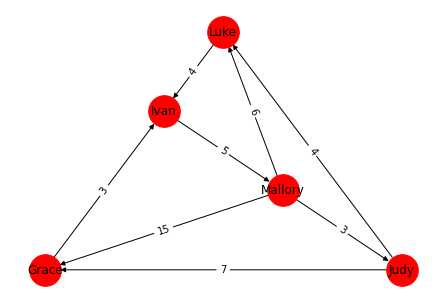

In [11]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(people)
G.add_weighted_edges_from(summed)
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

Next, ignoring the direction of the arrows (i.e. treating the graph as undirected), consider any cycle in the graph, for instance Grace - Ivan - Luke - Mallory. The key insight is that if we add a new set of debts, all for the same amount and in the same direction, between the members of the cycle, nobody's balance will change. This is true because each person will receive a new credit from the person preceding them in the cycle, and incur a new debt for the same value to the person following them in the cycle, for a net change of 0.

For instance, Grace - Ivan - Luke - Mallory is a cycle; if we ask Luke to give Ivan \\$3, Ivan to give Grace \\$3, Grace to give Mallory \\$3, and Mallory to give Like \\$3, in addition to all existing debts, nobody's balance has changed.

Also note that given a cycle, we can chose the amount and direction of the debt we add to exactly cancel out any one of the edges in the cycle. So by picking the amount and direction intelligently, we can remove one edge from any cycle without adding any new edges.

So this is the core idea of the algorithm: keep breaking cycles one by one, until there aren't any left.

After adjusting ['Grace', 'Ivan', 'Luke', 'Judy'] by 3:


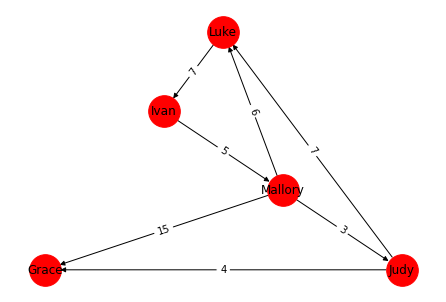

After adjusting ['Grace', 'Judy', 'Luke', 'Ivan', 'Mallory'] by -4:


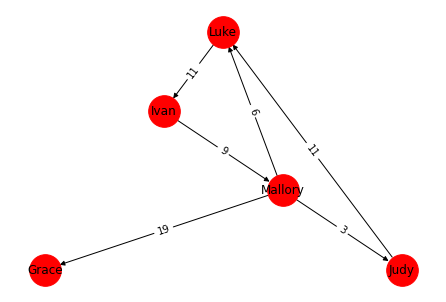

After adjusting ['Mallory', 'Ivan', 'Luke', 'Judy'] by -9:


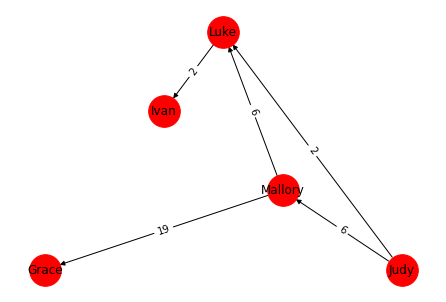

After adjusting ['Mallory', 'Judy', 'Luke'] by -6:


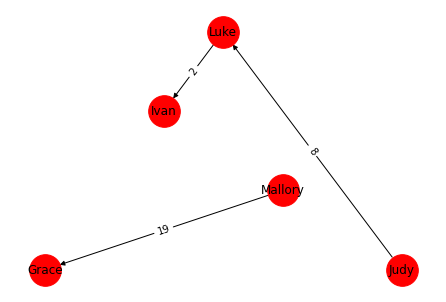

In [12]:
import matplotlib.pyplot as plt

def edge_inverter(edge):
    if edge[0] < edge[1]:
        return (1, (edge[0], edge[1]))
    else:
        return (-1, (edge[1], edge[0]))

def simplify_transactions(G, show_details=False):
    G = G.copy()
    while True:
        
        # 1 - find a cycle
        try:
            cycle = nx.algorithms.cycles.find_cycle(G.to_undirected())
        except nx.exception.NetworkXNoCycle:
            break
         
        # 2 - pick an arbitrary edge, e.g. the first one, and select its amount
        #     (amount_to_remove) and direction (inverted)
        inverted, edge_to_remove = edge_inverter(cycle[0])
        amount_to_remove = G[edge_to_remove[0]][edge_to_remove[1]]['weight'] * inverted
        
        # 3- iterate through nodes in the cycle and subtract (or add, depending
        #    on the edge's direction) the amount in question. Delete any edges that
        #    end up with 0 weight.
        for edge in cycle:
            inverter, edge = edge_inverter(edge)
            G[edge[0]][edge[1]]['weight'] -= amount_to_remove * inverter
            if G[edge[0]][edge[1]]['weight'] == 0:
                G.remove_edge(edge[0], edge[1])

        if show_details:
            print(f"After adjusting {[n[0] for n in cycle]} by {amount_to_remove}:")
            print_digraph(reorient_digraph(G), pos)
            plt.show()
    
    return G
        
simplified = simplify_transactions(G, show_details=True)

(`edge_inverter` just deals with the fact that we should reverse a debt if the edge is going backwards).

And we're done! We've gotten lucky and ended up with $n - 2$ transactions (we could have gotten $n - 1$ instead), as a strict subset of the original set of debts.

In [13]:
def to_transactions(graph):
    transactions = []
    for edge in graph.edges:
        inverter, (node1, node2) = edge_inverter(edge)
        owed = simplified[node1][node2]['weight'] * inverter
        transactions.append((node1, node2, owed))
    return transactions

show_transactions(to_transactions(simplified))

Mallory owes Grace $19
Luke owes Ivan $2
Judy owes Luke $8


### Complexity

The complexity analysis for this algorithm is a bit trickier. Finding a cycle is done via a DFS, and takes $O(m)$ operations (recall that _m_ is the number of transactions). This is done at most $O(m - n + 1) = O(m)$ times, so the total complexity is $O(m^2)$. There might be a clever way to find multiple cycles at once, but I'm not sure what that would be.

In total, we lose some performance (but obviously remain in P) in exchange for a solution that may be nicer in practice.

That's all for today! You can [download the Jupyter notebook this post is based on](debt-simplification.ipynb). Feel free to leave comments or suggestions below.

## References

- Verhoeff, Tom. "Settling multiple debts efficiently: An invitation to computing science." _Informatics in Education-An International Journal_ 3.1 (2004): 105-126. [Direct link](https://www.researchgate.net/profile/Tom_Verhoeff/publication/220396130_Settling_Multiple_Debts_Efficiently_An_Invitation_to_Computing_Science/links/00463519f239f8a553000000/Settling-Multiple-Debts-Efficiently-An-Invitation-to-Computing-Science.pdf)
